In [1]:
import pypsa
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
from entsoe2 import fetch_entsoe_data
from n_trim import drop_buses
from zones import assign_zones
from load_weighting import load_weight
from production_weighting import production_weight, storage_weight
from drop_buses import drop_buses
from DC_links_add import DC_links_add
from Add_key_generators import add_other_generators_Nordic, add_ror_generators_NO
from Plotting import plot_network_with_loadings
from Loading_lines_and_links_relative_quantified import loading_lines_and_links_relative_quantified
import os

1. Importing nordic grid from pypsa eur ex DC links to non-nordic countries

In [2]:
n = pypsa.Network("base_s_65_elec_.nc")

<frozen importlib._bootstrap>:488: RuntimeWarning:

numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject

INFO:pypsa.network.io:New version 1.0.2 available! (Current: 0.35.2)
INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, lines, links, loads, storage_units, stores


2. Assign zone column to loads. Drop H2 and battery buses. Adding generators with carrier 'other' to every bus, and 'ror' to NO_3 and NO_4. Adding load_Weight for buses and producdtion weight for generators.

In [ ]:
n = assign_zones(n)
drop_buses(n)
add_other_generators_Nordic(n)
add_ror_generators_NO(n)

load_weight(n)
n.buses
#Replace with production_weighting evetually. Needs to be done after we have added generators we want to include in the share calculation.
production_weight(n)
#storage_weight(n)
#n.generators


✅ Added 65 new 'other' PQ generators.
Found 6 buses in NO_3
Found 6 buses in NO_4


PyPSA Network 'Unnamed Network'
-------------------------------
Components:
 - Bus: 65
 - Carrier: 23
 - Generator: 455
 - Line: 101
 - Link: 7
 - Load: 65
 - StorageUnit: 62
Snapshots: 24

In [83]:
#print(n.storage_units.to_string())
#n.storage_units.columns


In [84]:
#n.storage_units_t.p_set 


In [85]:
"""pd.set_option('display.max_rows', None)
print(n.buses)

# Reset back to default
pd.reset_option('display.max_rows')"""

"pd.set_option('display.max_rows', None)\nprint(n.buses)\n\n# Reset back to default\npd.reset_option('display.max_rows')"

3. Remove battery and hydrogen related

3. Remove all from node in west denmark and add a slack generator

In [6]:
# Remove all generators, loads, and storage units for DK_1
dk1_buses = n.buses[n.buses['zone'] == 'DK_1'].index.tolist()
print(f"Found {len(dk1_buses)} buses in DK_1 zone")

# Remove components connected to DK_1 buses
for bus in dk1_buses:
    # Remove generators
    gens_to_remove = n.generators[n.generators['bus'] == bus].index.tolist()
    if gens_to_remove:
        n.remove("Generator", gens_to_remove)
        print(f"Removed {len(gens_to_remove)} generators from {bus}")
    
    # Remove loads
    loads_to_remove = n.loads[n.loads['bus'] == bus].index.tolist()
    if loads_to_remove:
        n.remove("Load", loads_to_remove)
        print(f"Removed {len(loads_to_remove)} loads from {bus}")
    
    # Remove storage units
    if not n.storage_units.empty:
        stor_to_remove = n.storage_units[n.storage_units['bus'] == bus].index.tolist()
        if stor_to_remove:
            n.remove("StorageUnit", stor_to_remove)
            print(f"Removed {len(stor_to_remove)} storage units from {bus}")

# Add one slack generator to DK_1
if dk1_buses:
    dk1_bus = dk1_buses[0]  # Use first DK_1 bus
    n.add(
        "Generator",
        name="slack_DK_1",
        bus=dk1_bus,
        p_min_pu=0,
        p_max_pu=1,
        carrier="slack",
        control="Slack"
    )
    print(f"✅ Added slack generator to {dk1_bus}")

Found 1 buses in DK_1 zone
Removed 10 generators from DK0 0
Removed 1 loads from DK0 0
✅ Added slack generator to DK0 0


In [86]:
#slack_gens = n.generators[n.generators["control"] == "Slack"]
#print(slack_gens)


4. Fetch the ENTSOE-E data regarding AC flow, DC flow, load and production per bidding zone. Can be very time consuming, think about wether you need to do this or not. 

In [8]:
loads_df, gens_df, ac_flows_df, dc_flows_df = fetch_entsoe_data(start_date="2023-01-01", timezone="Europe/Oslo")

In [9]:
gens_df_sum_before = gens_df.sum(axis=1)

import pandas as pd

# ENTSO-E technologies that should be aggregated into "Other"
other_sources = [
    "Fossil Brown coal/Lignite",
    "Fossil Peat",
    "Waste",
    "Other renewable",
    "Fossil Oil"
]

print("Before merge:")
print(f"Shape: {gens_df.shape}")
print(f"Number of zones: {len(gens_df.columns.get_level_values('Zone').unique())}")
print(f"Technologies for FI before: {gens_df['FI'].columns.tolist()}")

# Make sure "Other" exists for each zone
zones = gens_df.columns.get_level_values("Zone").unique()
for zone in zones:
    if ("Zone" in gens_df.columns.names and 
        (zone, "Other") not in gens_df.columns):
        gens_df[(zone, "Other")] = 0.0

# Go through each zone and aggregate "other_sources" into "Other"
for zone in zones:
    for src in other_sources:
        col = (zone, src)
        if col in gens_df.columns:
            gens_df[(zone, "Other")] += gens_df[col]
            gens_df.drop(columns=[col], inplace=True)

# Re-sort columns to keep order tidy
gens_df = gens_df.sort_index(axis=1)

print("\nAfter merge:")
print(f"Shape: {gens_df.shape}")
print(f"Technologies for FI after: {gens_df['FI'].columns.tolist()}")


Before merge:
Shape: (24, 69)
Number of zones: 11
Technologies for FI before: ['Biomass', 'Fossil Gas', 'Fossil Hard coal', 'Fossil Oil', 'Fossil Peat', 'Hydro Run-of-river and poundage', 'Nuclear', 'Other', 'Other renewable', 'Solar', 'Waste', 'Wind Onshore']

After merge:
Shape: (24, 62)
Technologies for FI after: ['Biomass', 'Fossil Gas', 'Fossil Hard coal', 'Hydro Run-of-river and poundage', 'Nuclear', 'Other', 'Solar', 'Wind Onshore']


In [10]:
#gens_df_sum_before
#gens_df.sum(axis=1)

In [82]:
#gens_df

6. Add nodes with a slack generator per country

In [12]:
# Coordinatees to buses is found in OSM as the GPS coordinates to static inverter plants related to the DC links

add_countries = {
    "DE": {"name": "Germany", "y": 54.07611776227856, "x": 10.02805057158303},
    "NL": {"name": "Netherlands", "y": 53.434444, "x": 6.865833},
    "GB": {"name": "Great Britain", "y": 55.1506, "x": -1.5510},
    "PL": {"name": "Poland", "y": 54.502111, "x": 16.891222},
    "LT": {"name": "Lithuania", "y": 55.681667, "x": 21.256667},
    "EE": {"name": "Estonia", "y": 59.384722, "x": 24.560278},
}
#, 9.3425
# Add Nordic sync grid buses using loop
for country_code, data in add_countries.items():
    n.add(
        "Bus",
        name=country_code,
        v_nom=380,
        y=data["y"],
        x=data["x"],
        carrier="AC"
    )
    n.add(
        "Generator",
        name=f"slack_{country_code}",
        bus=country_code,
        carrier="slack",
        control="Slack"
    )

print(" Added buses:", list(add_countries.keys()))

n.add("Generator",
        name=f"slack_Forsmark",
        bus='SE1 16',
        carrier="slack",
        control="Slack")



 Added buses: ['DE', 'NL', 'GB', 'PL', 'LT', 'EE']


Index(['slack_Forsmark'], dtype='object')

7. Add DC links between nordic and non-nordic countries

In [13]:
DC_links_add(n, r"links_needed.csv")

Index(['relation/8184629-300-DC'], dtype='object')
Index(['relation/8184629-300-DC'], dtype='object')


Missing buses: {'way/24534144', 'way/98216482'}


PyPSA Network 'Unnamed Network'
-------------------------------
Components:
 - Bus: 71
 - Carrier: 23
 - Generator: 453
 - Line: 101
 - Link: 15
 - Load: 64
 - StorageUnit: 62
Snapshots: 24

In [14]:
# 7. Network summary and verification

print("=== NETWORK SUMMARY ===")
print(f"Buses: {len(n.buses)}")
print(f"Generators: {len(n.generators)}")
print(f"Links: {len(n.links)}")
print(f"Lines: {len(n.lines)}")
print(f"Loads: {len(n.loads)}")

print("\n=== NORDIC SYNC GRID BUSES ===")
nordic_sync_buses = ["DE", "NL"]
for bus in nordic_sync_buses:
    if bus in n.buses.index:
        print(f"✅ {bus}: {n.buses.loc[bus, 'v_nom']} kV")



print("\n=== SLACK GENERATORS ===")
slack_gens = (n.generators[n.generators['carrier'] == 'slack'])
print(f"Total slack generators: {len(slack_gens)}")
print("   - No p_nom specified (PyPSA handles automatically)")
print("   - DK_1 cleaned: all generators, loads, storage units removed")
print("   - One slack generator added to DK_1")

print("\n=== ZONE DISTRIBUTION ===")
zone_counts = n.buses['zone'].value_counts()
print(zone_counts)

print(n.generators[n.generators['control'] == 'Slack'])


=== NETWORK SUMMARY ===
Buses: 71
Generators: 453
Links: 15
Lines: 101
Loads: 64

=== NORDIC SYNC GRID BUSES ===
✅ DE: 380.0 kV
✅ NL: 380.0 kV

=== SLACK GENERATORS ===
Total slack generators: 8
   - No p_nom specified (PyPSA handles automatically)
   - DK_1 cleaned: all generators, loads, storage units removed
   - One slack generator added to DK_1

=== ZONE DISTRIBUTION ===
zone
SE_3    13
FI       9
NO_2     8
NO_4     6
NO_3     6
NO_1     5
SE_2     5
SE_4     4
SE_1     4
NO_5     3
DK_1     1
DK_2     1
Name: count, dtype: int64
                   bus control type  p_nom  p_nom_mod  p_nom_extendable  \
Generator                                                                 
slack_DK_1       DK0 0   Slack         0.0        0.0             False   
slack_DE            DE   Slack         0.0        0.0             False   
slack_NL            NL   Slack         0.0        0.0             False   
slack_GB            GB   Slack         0.0        0.0             False   
slack_PL

checking  ROR powerplants NO_3 and NO_4. Not true capacity,  and the generators are assigned to all buses, which is probably not true. 

In [16]:
ror = n.generators[n.generators["carrier"].astype(str).str.lower() == "ror"]
print("ROR by zone (count):")
print(ror["zone"].astype(str).value_counts(dropna=False).to_string())
print("\nROR by zone (MW):")
print(ror.groupby(ror["zone"].astype(str))["p_nom"].sum().sort_index().to_string())

ROR by zone (count):
zone
FI      7
NO_3    6
NO_4    6
SE_2    4
SE_3    3
NO_1    2
SE_1    2
NO_5    1
NO_2    1

ROR by zone (MW):
zone
FI      1470.6
NO_1     632.5
NO_2     185.0
NO_3     300.0
NO_4     300.0
NO_5      75.0
SE_1     212.0
SE_2     846.0
SE_3     221.0


Checking capacity for each technology for each bidding zone

In [17]:

techs = set()

if not n.generators.empty and "carrier" in n.generators.columns:
    techs.update(n.generators["carrier"].dropna().unique())

if hasattr(n, "storage_units") and not n.storage_units.empty and "carrier" in n.storage_units.columns:
    techs.update(n.storage_units["carrier"].dropna().unique())

for t in sorted(techs):
    print(t)

print(f"\nTotal technologies: {len(techs)}")


def capacity_by(component):
    if component is None or getattr(component, "empty", True):
        return pd.DataFrame()
    required = {"zone", "carrier", "p_nom"}
    if not required.issubset(component.columns):
        return pd.DataFrame()
    df = component[["zone", "carrier", "p_nom"]].dropna(subset=["zone", "carrier"]).copy()
    df["zone"] = df["zone"].astype(str)
    cap = (
        df.groupby(["zone", "carrier"]) ["p_nom"]
          .sum()
          .unstack(fill_value=0)
          .sort_index()
    )
    cap = cap.reindex(sorted(cap.columns), axis=1)
    return cap.round(1)

gen_cap = capacity_by(n.generators)
stor_cap = capacity_by(n.storage_units)
pd.set_option('display.max_rows', None)       # show all rows
pd.set_option('display.max_columns', None)    # show all columns (optional)
pd.set_option('display.width', 0)             # no line wrap (optional)

print("\nGenerators capacity (MW) by zone and technology:")
print(gen_cap)

print("\nStorage units capacity (MW) by zone and technology:")
print(stor_cap)

CCGT
PHS
biomass
coal
hydro
nuclear
offwind-ac
offwind-dc
offwind-float
oil
onwind
other
ror
slack
solar
solar-hsat

Total technologies: 16

Generators capacity (MW) by zone and technology:
carrier    CCGT  biomass    coal  nuclear  offwind-ac  offwind-dc  \
zone                                                                
DK_2     1038.0    311.0  1266.0      0.0      1050.0         0.0   
FI       2709.6   3226.9  1661.8   4362.0        73.0         0.0   
NO_1        0.0      0.0     0.0      0.0         0.0         0.0   
NO_2        0.0      0.0     0.0      0.0        50.0         0.0   
NO_3        0.0      0.0     0.0      0.0         0.0         0.0   
NO_4      459.0      0.0     0.0      0.0         0.0         0.0   
NO_5      294.0      0.0     0.0      0.0        88.0         0.0   
SE_1        0.0     35.0     0.0      0.0        10.3         0.0   
SE_2        0.0    245.0     0.0      0.0         2.3         0.0   
SE_3       50.0    664.0     0.0   8617.0        53

In [18]:
if gens_df is None or gens_df.empty:
    print("gen_df is empty or None")
else:
    techs = sorted(set(gens_df.columns.get_level_values("Technology")))
    for t in techs:
        print(t)
    print(f"\nTotal technologies: {len(techs)}")

Biomass
Fossil Gas
Fossil Hard coal
Hydro Pumped Storage
Hydro Run-of-river and poundage
Hydro Water Reservoir
Nuclear
Other
Solar
Wind Offshore
Wind Onshore

Total technologies: 11


Lots of stuff. Mapping ENTSO-E to carrier. Distributing generation and loads based of weighting factor. 

In [53]:
# REPLACEMENT FOR CELL 24 - Copy this to replace your problematic cell

# Reindex time series to network snapshots
n.generators_t.p_set    = n.generators_t.p_set.reindex(n.snapshots, columns=n.generators.index, fill_value=0.0)
n.storage_units_t.p_set = n.storage_units_t.p_set.reindex(n.snapshots, columns=n.storage_units.index, fill_value=0.0)
n.loads_t.p_set         = n.loads_t.p_set.reindex(n.snapshots, columns=n.loads.index, fill_value=0.0)



# ENTSO-E tech -> carriers (swapped mapping); build inverse carrier -> ENTSO-E
ENTSOE_TO_CARRIERS = {
    "Fossil Gas":["ccgt","ocgt"],
    "Biomass":["biomass"],
    "Fossil Hard coal":["coal"],
    #"Fossil Brown coal/Lignite":["other"],
    "Fossil Oil":["oil"],
    #"Fossil Peat":["other"],
    "Nuclear":["nuclear"],
    "Wind Onshore":["onwind"],
    "Wind Offshore":["offwind-ac","offwind-dc","offwind-float"],
    "Solar":["solar","solar-hsat"],
    "Hydro Run-of-river and poundage":["ror"],
    "Hydro Pumped Storage":["phs"],
    "Hydro Water Reservoir":["hydro"],
    #"Waste":["other"],
    "Other":["other"],
    #"Other renewable":["other"],
    }

CARRIER_TO_ENTSOE = {c.lower().strip(): t for t, cs in ENTSOE_TO_CARRIERS.items() for c in cs}


"""def distribute_generation(comp, out_ts, col_nom="p_nom", cap=True):
    if comp.empty:
        return
    zone = comp["zone"].astype(str)
    tech = comp["carrier"].astype(str).str.lower().map(CARRIER_TO_ENTSOE).fillna("Other")
    for (Z, T), idx in comp.groupby([zone.rename("Zone"), tech.rename("Technology")]).groups.items():
        if (Z, T) not in gens_df.columns:
            continue
        s = gens_df[(Z, T)].reindex(n.snapshots).fillna(0.0).to_numpy()
        idx = pd.Index(idx)
        caps = comp.loc[idx, col_nom].astype(float).to_numpy() if len(idx) else np.array([])
        S = caps.sum() if len(idx) else 0.0
        # Fallback: if no units for this tech in zone (or zero capacity), spread across all units in the zone
        if len(idx) == 0 or S <= 0:
            idx = comp.index[zone == Z]
            if len(idx) == 0:
                continue
            caps = comp.loc[idx, col_nom].astype(float).to_numpy()
            S = caps.sum()
        share = (s[:, None] * (caps / S)) if S > 0 else (s[:, None] / len(idx))
        out_ts.loc[:, idx] = np.minimum(share, caps) if cap else share
"""        


def distribute_loads_by_share(loads_df):
    if loads_df is None or loads_df.empty:
        return
    
    # Map bus load share to loads
    load_share = n.buses["load_share"].reindex(n.loads["bus"]).fillna(0.0)
    
    zones = n.loads["zone"]
    
    for Z, idx in zones.groupby(zones).groups.items():
        
        if Z not in loads_df.columns or len(idx) == 0:
            continue
        
        # Zone-level load time series
        zone_ts = loads_df[Z].reindex(n.snapshots).fillna(0.0).to_numpy()
        
        # Local bus weights
        w = load_share.loc[idx]
        W = w.sum()
        
        if W <= 0:
            print(f"⚠ Zone {Z} has zero weighting. Even distribution.")
            w = np.ones(len(idx)) / len(idx)
        else:
            w = w / W
        
        # Weighted distribution to loads at buses
        n.loads_t.p_set.loc[:, idx] = pd.DataFrame(
            zone_ts[:, None] * w.values[None, :],
            index=n.snapshots,
            columns=idx
        )   


def distribute_production_from_shares(n, gens_df):
    """
    Distribute zone-tech aggregated production in gens_df
    to individual generators using n.generators.production_share.
    """

    gen = n.generators

    # Ensure metadata exists and aligned with gens_df
    gen["Zone"] = gen["zone"].astype(str)
    gen["Tech"] = (
        gen["carrier"]
        .astype(str)
        .str.lower()
        .str.strip()
        .map(CARRIER_TO_ENTSOE)
        .fillna("Other")
    )

    if "production_share" not in gen.columns:
        raise ValueError("Missing production_share")

    snaps = n.snapshots
    n.generators_t.p_set.loc[:, :] = 0.0  # reset

    for (Z, T) in gens_df.columns:
        # FIND GENERATORS MATCHING ZONE + TECH ✅
        idx = gen.index[(gen["Zone"] == Z) & (gen["Tech"] == T)]
        if len(idx) == 0:
            continue

        # Zone-tech time series
        ts = gens_df[(Z, T)].reindex(snaps).to_numpy()
        w = gen.loc[idx, "production_share"].to_numpy()

        # Distribute production
        n.generators_t.p_set.loc[:, idx] = ts[:, None] * w[None, :]

        print(f"✅ distributed: Zone={Z} Tech={T} Units={len(idx)}")


def distribute_storage_from_shares(n, gens_df):
    """
    Distribute zone-tech aggregated production in gens_df
    to individual generators using n.generators.production_share.
    """

    gen = n.storage_units

    # Ensure metadata exists and aligned with gens_df
    gen["Zone"] = gen["zone"].astype(str)
    gen["Tech"] = (
        gen["carrier"]
        .astype(str)
        .str.lower()
        .str.strip()
        .map(CARRIER_TO_ENTSOE)
        .fillna("Other")
    )

    if "production_share" not in gen.columns:
        raise ValueError("Missing production_share")

    snaps = n.snapshots
    n.storage_units_t.p_set.loc[:, :] = 0.0  # reset

    for (Z, T) in gens_df.columns:
        # FIND GENERATORS MATCHING ZONE + TECH ✅
        idx = gen.index[(gen["Zone"] == Z) & (gen["Tech"] == T)]
        if len(idx) == 0:
            continue

        # Zone-tech time series
        ts = gens_df[(Z, T)].reindex(snaps).to_numpy()
        w = gen.loc[idx, "production_share"].to_numpy()

        # Distribute production
        n.storage_units_t.p_set.loc[:, idx] = ts[:, None] * w[None, :]

        print(f"✅ distributed: Zone={Z} Tech={T} Units={len(idx)}")




# Run distributions (allow generators to exceed p_nom, keep storage capped)

#distribute_zone_tech(n.generators, n.generators_t.p_set, gens_df, cap=False)
#distribute_zone_tech(n.storage_units, n.storage_units_t.p_set, gens_df, cap=True)

#distribute_generation(n.generators,    n.generators_t.p_set, cap=False)  #generators
distribute_production_from_shares(n, gens_df)
distribute_storage_from_shares(n,gens_df)   #storage units
distribute_loads_by_share(loads_df)
#distribute_loads_equal(loads_df)



# SKIP ZONE MISMATCH CHECK - Just continue
print("✅ Network data distributed successfully")

# Quick totals

print("Produksjon (MW):\n", (n.generators_t.p_set.sum(1) + n.storage_units_t.p_set.clip(lower=0).sum(axis=1)))
print("\nLast (MW):\n", (n.loads_t.p_set.sum(1)))


✅ distributed: Zone=DK_2 Tech=Biomass Units=1
✅ distributed: Zone=DK_2 Tech=Fossil Gas Units=1
✅ distributed: Zone=DK_2 Tech=Fossil Hard coal Units=1
✅ distributed: Zone=DK_2 Tech=Other Units=1
✅ distributed: Zone=DK_2 Tech=Solar Units=2
✅ distributed: Zone=DK_2 Tech=Wind Offshore Units=3
✅ distributed: Zone=DK_2 Tech=Wind Onshore Units=1
✅ distributed: Zone=FI Tech=Biomass Units=9
✅ distributed: Zone=FI Tech=Fossil Gas Units=7
✅ distributed: Zone=FI Tech=Fossil Hard coal Units=4
✅ distributed: Zone=FI Tech=Hydro Run-of-river and poundage Units=7
✅ distributed: Zone=FI Tech=Nuclear Units=2
✅ distributed: Zone=FI Tech=Other Units=9
✅ distributed: Zone=FI Tech=Solar Units=16
✅ distributed: Zone=FI Tech=Wind Onshore Units=9
✅ distributed: Zone=NO_1 Tech=Hydro Run-of-river and poundage Units=2
✅ distributed: Zone=NO_1 Tech=Other Units=5
✅ distributed: Zone=NO_1 Tech=Wind Onshore Units=5
✅ distributed: Zone=NO_2 Tech=Hydro Run-of-river and poundage Units=1
✅ distributed: Zone=NO_2 Tech=Othe

In [ ]:
expected_vals = gens_df.sum(axis=1)
actual_vals = n.generators_t.p_set.sum(axis=1) + n.storage_units_t.p_set.clip(lower=0).sum(axis=1)
diff = actual_vals - expected_vals
diff
#print(sorted(n.generators["carrier"].unique()))
#gens_df
#Some production did still not get distributed properly. Perhaps missing technology for some buses? Check ENTSO vs n.generators. Think this is fixed now




snapshot
2023-01-01 00:00:00   -1.000000e-02
2023-01-01 01:00:00   -2.182787e-11
2023-01-01 02:00:00   -1.455192e-11
2023-01-01 03:00:00    0.000000e+00
2023-01-01 04:00:00   -1.000000e-02
2023-01-01 05:00:00    0.000000e+00
2023-01-01 06:00:00   -1.000000e-02
2023-01-01 07:00:00    0.000000e+00
2023-01-01 08:00:00   -7.275958e-12
2023-01-01 09:00:00   -1.455192e-11
2023-01-01 10:00:00    7.275958e-12
2023-01-01 11:00:00    0.000000e+00
2023-01-01 12:00:00    7.275958e-12
2023-01-01 13:00:00   -1.455192e-11
2023-01-01 14:00:00    7.275958e-12
2023-01-01 15:00:00    7.275958e-12
2023-01-01 16:00:00    1.455192e-11
2023-01-01 17:00:00    7.275958e-12
2023-01-01 18:00:00    1.455192e-11
2023-01-01 19:00:00    7.275958e-12
2023-01-01 20:00:00    0.000000e+00
2023-01-01 21:00:00    7.275958e-12
2023-01-01 22:00:00   -1.000000e-02
2023-01-01 23:00:00    1.455192e-11
dtype: float64

In [55]:
old = "relation/8184632-500-DC"
new = "Skagerak"  # whatever name you want

# Rename in the static link table
n.links = n.links.rename(index={old: new})
n.links.loc["Skagerak", "p_nom"] = 1634


In [56]:
old = "relation/3391954-500-DC"
new = "Fenno-Skan 2"  # whatever name you want

# Rename in the static link table
n.links = n.links.rename(index={old: new})




In [57]:
old = "relation/8184629-300-DC"
new = "Konti-Skan"  # whatever name you want

# Rename in the static link table
n.links = n.links.rename(index={old: new})



In [58]:
#dc_flows_df
#print(n.links)
dc_flows_df_mapping = {
    "DE_LU<->DK_2": "Kontek",
    "DE_LU<->NO_2": "NordLink",
    "DE_LU<->SE_4": "Baltic Cable", #Need to add this link to our model. Done
    #"DK_1<->NL": "actual_link_name_here",  #ignore this link as it does not connect to a nordic sync grid bidding zone
    "DK_1<->NO_2": "Skagerak",
    "EE<->FI": "Estlink",
    "FI<->SE_3": "Fenno-Skan 2",
    "GB<->NO_2": "North Sea Link",
    "LT<->SE_4": "NordBalt",
    "NL<->NO_2": "NorNed",
    "PL<->SE_4": "SwePol Link",
    "DK_1<->SE_3": "Konti-Skan",
    "DK_1<->DK_2": "relation/5487095-400-DC"
    #"SE_3<->SE_4":"relation/8184633-300-DC" Cross border physical flow for this link is infeasible to determine, as ENTSO only provides the total flow between bidding zones. Ignore for now.
}

dc_flows_df = dc_flows_df.rename(columns=dc_flows_df_mapping)
#dc_flows_df

In [59]:
#Assigning load to DC links
n.links_t.p_set = n.links_t.p_set.reindex(
    columns=n.links.index, fill_value=0.0
)
for col in dc_flows_df.columns:
    if col in n.links.index:
        n.links_t.p_set[col] = dc_flows_df[col]
    else:
        print(f"Column {col} not found in network links.")





Column DK_1<->NL not found in network links.
Column SE_3<->SE_4 not found in network links.


In [89]:
try:
    n.remove("Link", "relation/3391931-350-DC")
except KeyError:
    print("Link 'relation/3391931-350-DC' not found in network or is already removed.")
except Exception as e:
    print(f"An error occurred while removing link: {e}")

print("relation/3391931-350-DC" in n.links.index)


Link 'relation/3391931-350-DC' not found in network or is already removed.
False


In [61]:
n.lpf()

INFO:pypsa.network.power_flow:Performing linear load-flow on AC sub-network <pypsa.networks.SubNetwork object at 0x000001B8E6CDC530> for snapshot(s) DatetimeIndex(['2023-01-01 00:00:00', '2023-01-01 01:00:00',
               '2023-01-01 02:00:00', '2023-01-01 03:00:00',
               '2023-01-01 04:00:00', '2023-01-01 05:00:00',
               '2023-01-01 06:00:00', '2023-01-01 07:00:00',
               '2023-01-01 08:00:00', '2023-01-01 09:00:00',
               '2023-01-01 10:00:00', '2023-01-01 11:00:00',
               '2023-01-01 12:00:00', '2023-01-01 13:00:00',
               '2023-01-01 14:00:00', '2023-01-01 15:00:00',
               '2023-01-01 16:00:00', '2023-01-01 17:00:00',
               '2023-01-01 18:00:00', '2023-01-01 19:00:00',
               '2023-01-01 20:00:00', '2023-01-01 21:00:00',
               '2023-01-01 22:00:00', '2023-01-01 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', freq=None)
INFO:pypsa.network.power_flow:Performing linear load

Checking the relative line loadings and link loadings [%]

In [64]:
loading_lines_and_links_relative_quantified(n, snapshot_number=17, number_of_displayed_links=100, number_of_displayed_lines=100)



=== Zero Loaded Components ===
Zero-loaded AC Lines: 0
Zero-loaded HVDC Links: 3

=== AC Lines loading %===
       bus0    bus1  loading_percent
3     FI1 1   FI1 3         0.079222
21    NO1 1  NO1 13         1.311392
6     FI1 1   FI1 8         1.451101
7     FI1 1   FI1 8         1.451101
52   NO1 22   NO1 7         1.468515
68   SE1 12  SE1 24         1.818188
47   NO1 20  NO1 25         2.255083
14    FI1 4   FI1 8         2.837216
1     FI1 0   FI1 4         2.965004
26   NO1 11  NO1 16         3.875432
61    SE1 0   SE1 5         3.947884
46   NO1 19  NO1 27         4.090508
35   NO1 14   NO1 7         4.371308
12    FI1 3   NO1 4         5.611650
13    FI1 3  SE1 12         6.064529
11    FI1 2   FI1 6         6.268910
4     FI1 1   FI1 6         6.270806
5     FI1 1   FI1 6         6.270806
66   SE1 10   SE1 6         6.283589
30   NO1 11   NO1 5         6.446983
83   SE1 17   SE1 9         6.944622
100   SE1 6   SE1 8         7.042779
8     FI1 1  SE1 12         7.157775
18 

Plotting the network with bidding zones, line loading and link loading. Arrows indicates power flow direction. 

c:\Users\aleks\Documents\UsN\FM4017 - Project\FM4017-Project Repo Aleks\FM4017-Project\Plotting.py:43: DeprecatedWarning:

plot is deprecated as of 0.34 and will be removed in 1.0. Use `n.plot.map()` as a drop-in replacement instead.



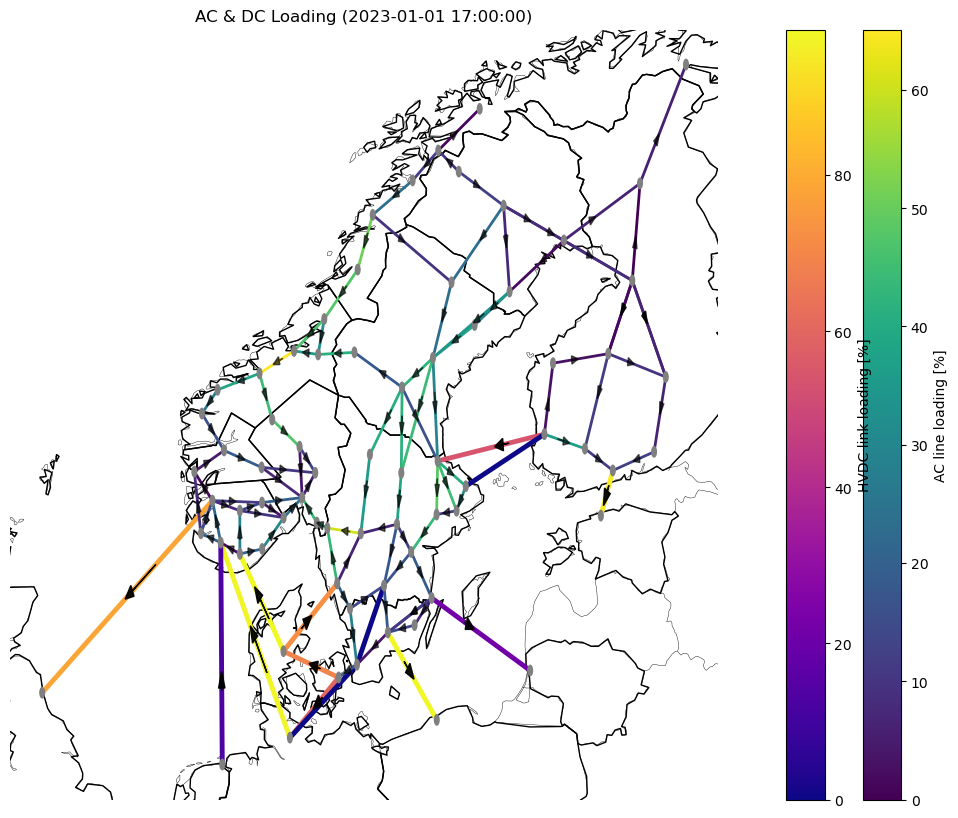

In [65]:
plot_network_with_loadings(n, snapshot_number=17)

In [66]:
n.lines_t.p0['57']

snapshot
2023-01-01 00:00:00   -178.281375
2023-01-01 01:00:00   -157.142922
2023-01-01 02:00:00   -144.363816
2023-01-01 03:00:00   -121.163045
2023-01-01 04:00:00    -87.117334
2023-01-01 05:00:00    -55.091416
2023-01-01 06:00:00   -102.516892
2023-01-01 07:00:00    -86.490544
2023-01-01 08:00:00    -61.595654
2023-01-01 09:00:00    -60.885927
2023-01-01 10:00:00    -71.500290
2023-01-01 11:00:00    -67.148049
2023-01-01 12:00:00    -61.399514
2023-01-01 13:00:00    -78.940650
2023-01-01 14:00:00   -176.065441
2023-01-01 15:00:00   -286.236760
2023-01-01 16:00:00   -460.736738
2023-01-01 17:00:00   -450.997818
2023-01-01 18:00:00   -503.187797
2023-01-01 19:00:00   -480.003041
2023-01-01 20:00:00   -464.145608
2023-01-01 21:00:00   -486.249331
2023-01-01 22:00:00   -501.575662
2023-01-01 23:00:00   -459.395007
Name: 57, dtype: float64

In [67]:
#ac_flows_df
#n.buses.zone["NO1 0"]
#n.buses[n.buses.zone == 'NO_5']
#n.lines
#n.loads_t

In [68]:
bus_name = "SE1 16"
gens_on_bus = n.generators.index[n.generators["bus"] == bus_name]
print(gens_on_bus)


Index(['SE1 16 biomass', 'SE1 16 0 solar-hsat', 'SE1 16 0 offwind-ac',
       'SE1 16 0 offwind-float', 'SE1 16 0 onwind', 'SE1 16 0 offwind-dc',
       'SE1 16 0 solar', 'SE1 16 ror', 'SE1 16_other', 'slack_Forsmark'],
      dtype='object', name='Generator')


In [69]:
#n.links
#n.buses

In [70]:
# Group by bus + carrier and sum installed nominal power
capacity_by_bus_and_carrier = (
    n.generators
    .groupby(["bus", "carrier"])["p_nom"]
    .sum()
    .unstack(fill_value=0)
)

print(capacity_by_bus_and_carrier)


carrier    CCGT  biomass         coal  nuclear   offwind-ac  offwind-dc  \
bus                                                                       
DE          0.0     0.00     0.000000      0.0     0.000000         0.0   
DK0 0       0.0     0.00     0.000000      0.0     0.000000         0.0   
DK1 0    1038.0   311.00  1266.000000      0.0  1050.000000         0.0   
EE          0.0     0.00     0.000000      0.0     0.000000         0.0   
FI1 0     252.0   353.00   788.256098   3370.0    29.866738         0.0   
FI1 1      68.0   465.30     0.000000      0.0     6.168482         0.0   
FI1 2     348.3   823.00    39.200000    992.0     3.331606         0.0   
FI1 3      32.8     6.00     0.000000      0.0     2.556392         0.0   
FI1 4       0.0   462.50   230.484239      0.0    14.258607         0.0   
FI1 5    1566.3   236.14   603.868707      0.0     4.547482         0.0   
FI1 6       0.0   416.10     0.000000      0.0     0.000000         0.0   
FI1 7     439.5    75.70 

In [71]:
#n.generators_t

In [72]:
# Ensure generators have zone mapped
n.generators["zone"] = n.generators["bus"].map(n.buses["zone"])

zone = "SE_3"

# Filter generators in that zone
gens_in_zone = n.generators[n.generators["zone"] == zone]

# Group by carrier → sum timeseries for each carrier separately
production_by_carrier = (
    n.generators_t.p[gens_in_zone.index]
    .groupby(gens_in_zone["carrier"], axis=1)
    .sum()
)

print(production_by_carrier)



carrier              CCGT  biomass  nuclear  offwind-ac  offwind-dc  \
snapshot                                                              
2023-01-01 00:00:00   0.1      0.0   5799.0         0.0         0.0   
2023-01-01 01:00:00   0.2      0.0   5800.0         0.0         0.0   
2023-01-01 02:00:00   0.1      0.0   5799.0         0.0         0.0   
2023-01-01 03:00:00   0.1      0.0   5799.0         0.0         0.0   
2023-01-01 04:00:00   0.1      0.0   5800.0         0.0         0.0   
2023-01-01 05:00:00   0.1      0.0   5800.0         0.0         0.0   
2023-01-01 06:00:00   0.1      0.0   5799.0         0.0         0.0   
2023-01-01 07:00:00   0.1      0.0   5799.0         0.0         0.0   
2023-01-01 08:00:00   0.0      0.0   5798.0         0.0         0.0   
2023-01-01 09:00:00   0.0      0.0   5798.0         0.0         0.0   
2023-01-01 10:00:00   0.1      0.0   5798.0         0.0         0.0   
2023-01-01 11:00:00   0.1      0.0   5798.0         0.0         0.0   
2023-0

C:\Users\aleks\AppData\Local\Temp\ipykernel_57872\92639574.py:12: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



In [73]:
#validate = loads_df.sum(axis=1) - n.loads_t.p_set.sum(1)
#validate

techs = (
        n.generators["carrier"].astype(str).str.lower().str.strip()
        .map(CARRIER_TO_ENTSOE).fillna("Other")
    )

# Per-snapshot production by technology
prod_per_tech = n.generators_t.p_set.groupby(techs, axis=1).sum()

# Example: inspect first hours
print(prod_per_tech.head(24))



carrier              Biomass  Fossil Gas  Fossil Hard coal  Fossil Oil  \
snapshot                                                                 
2023-01-01 00:00:00   882.55      369.14            549.95         0.0   
2023-01-01 01:00:00   882.13      381.83            543.61         0.0   
2023-01-01 02:00:00   888.06      384.80            546.45         0.0   
2023-01-01 03:00:00   900.98      371.60            543.22         0.0   
2023-01-01 04:00:00   902.01      383.67            549.09         0.0   
2023-01-01 05:00:00   914.41      369.30            542.52         0.0   
2023-01-01 06:00:00   932.37      372.12            542.19         0.0   
2023-01-01 07:00:00   929.12      372.24            544.15         0.0   
2023-01-01 08:00:00   944.56      365.86            544.77         0.0   
2023-01-01 09:00:00   931.59      376.02            544.40         0.0   
2023-01-01 10:00:00   935.81      376.90            542.05         0.0   
2023-01-01 11:00:00   941.95      403.

C:\Users\aleks\AppData\Local\Temp\ipykernel_57872\2737710968.py:10: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



In [74]:
prod_per_tech = gens_df.groupby(level="Technology", axis=1).sum()
print(prod_per_tech.head(24))

Technology           Biomass  Fossil Gas  Fossil Hard coal  \
Snapshot                                                     
2023-01-01 00:00:00   882.55      369.15            549.95   
2023-01-01 01:00:00   882.13      381.83            543.61   
2023-01-01 02:00:00   888.06      384.80            546.45   
2023-01-01 03:00:00   900.98      371.60            543.22   
2023-01-01 04:00:00   902.01      383.68            549.09   
2023-01-01 05:00:00   914.41      369.30            542.52   
2023-01-01 06:00:00   932.37      372.13            542.19   
2023-01-01 07:00:00   929.12      372.24            544.15   
2023-01-01 08:00:00   944.56      365.86            544.77   
2023-01-01 09:00:00   931.59      376.02            544.40   
2023-01-01 10:00:00   935.81      376.90            542.05   
2023-01-01 11:00:00   941.95      403.23            542.27   
2023-01-01 12:00:00   937.82      383.14            541.97   
2023-01-01 13:00:00   934.49      374.91            543.37   
2023-01-

C:\Users\aleks\AppData\Local\Temp\ipykernel_57872\1573451352.py:1: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



In [75]:
other_gens = n.generators[n.generators["carrier"] == "Other"]
print(other_gens)


Empty DataFrame
Columns: [bus, control, type, p_nom, p_nom_mod, p_nom_extendable, p_nom_min, p_nom_max, p_min_pu, p_max_pu, p_set, e_sum_min, e_sum_max, q_set, sign, carrier, marginal_cost, marginal_cost_quadratic, active, build_year, lifetime, capital_cost, efficiency, committable, start_up_cost, shut_down_cost, stand_by_cost, min_up_time, min_down_time, up_time_before, down_time_before, ramp_limit_up, ramp_limit_down, ramp_limit_start_up, ramp_limit_shut_down, weight, p_nom_opt, zone, production_share, Zone, Tech]
Index: []


In [76]:
#n.generators
gen_n = n.generators_t.p_set.sum(axis=1) + n.storage_units_t.p_set.clip(lower=0).sum(axis=1)
print(gen_n)

gen_ENTSO = gens_df.sum(axis=1)
print(gen_ENTSO)

diff = gen_n - gen_ENTSO
print('networks missing production per snapshot {}'.format(diff))



snapshot
2023-01-01 00:00:00    37916.020
2023-01-01 01:00:00    37054.100
2023-01-01 02:00:00    36132.930
2023-01-01 03:00:00    35583.290
2023-01-01 04:00:00    35263.230
2023-01-01 05:00:00    35278.930
2023-01-01 06:00:00    35625.980
2023-01-01 07:00:00    35956.290
2023-01-01 08:00:00    36448.665
2023-01-01 09:00:00    37374.010
2023-01-01 10:00:00    38046.370
2023-01-01 11:00:00    39007.565
2023-01-01 12:00:00    39496.875
2023-01-01 13:00:00    39880.180
2023-01-01 14:00:00    40673.010
2023-01-01 15:00:00    42963.850
2023-01-01 16:00:00    46272.810
2023-01-01 17:00:00    47263.780
2023-01-01 18:00:00    47304.300
2023-01-01 19:00:00    47107.480
2023-01-01 20:00:00    46373.510
2023-01-01 21:00:00    45630.800
2023-01-01 22:00:00    44645.770
2023-01-01 23:00:00    43220.500
dtype: float64
Snapshot
2023-01-01 00:00:00    37916.030
2023-01-01 01:00:00    37054.100
2023-01-01 02:00:00    36132.930
2023-01-01 03:00:00    35583.290
2023-01-01 04:00:00    35263.240
2023-01-01

In [77]:
# Filter generators with carrier == "other"
mask_other = n.generators["carrier"].str.lower() == "other"

# Extract their zones
zones = n.generators.loc[mask_other, "zone"]

# Extract time series for those generators
other_gen_ts = n.generators_t.p_set.loc[:, mask_other]

# Sum per snapshot by zone
other_per_zone = other_gen_ts.groupby(zones, axis=1).sum()

print(other_per_zone.head(100))


zone                  DK_2      FI  NO_1   NO_2   NO_3   NO_4   NO_5   SE_1  \
snapshot                                                                      
2023-01-01 00:00:00  61.45  325.96  7.70  12.74  22.59  39.29  14.34  19.21   
2023-01-01 01:00:00  59.52  323.27  7.78  12.73  22.63  44.42   9.36  19.41   
2023-01-01 02:00:00  60.23  325.58  7.26  12.75  22.78  44.49   9.23  19.51   
2023-01-01 03:00:00  59.77  325.24  7.64  12.72  23.26  39.56   9.17  19.71   
2023-01-01 04:00:00  60.46  328.09  7.11  12.74  22.89  39.15   9.18  19.81   
2023-01-01 05:00:00  59.39  328.17  7.68  12.75  22.99  35.80   9.40  19.81   
2023-01-01 06:00:00  59.88  332.42  7.80  12.73  22.91  33.66   9.45  20.01   
2023-01-01 07:00:00  60.10  336.15  8.32  12.73  22.76  30.22   9.33  19.84   
2023-01-01 08:00:00  59.74  342.29  8.51  12.73  21.82  32.88   9.29  19.05   
2023-01-01 09:00:00  59.18  344.96  8.67  12.76  21.68  35.63   9.49  18.85   
2023-01-01 10:00:00  60.15  346.52  9.09  12.70  22.

C:\Users\aleks\AppData\Local\Temp\ipykernel_57872\3754820833.py:11: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



In [78]:
n.generators["carrier"].unique()


array(['CCGT', 'biomass', 'coal', 'nuclear', 'oil', 'solar-hsat',
       'offwind-ac', 'offwind-float', 'onwind', 'offwind-dc', 'solar',
       'ror', 'other', 'slack'], dtype=object)

In [79]:
import pandas as pd

# Select the first snapshot
snap = n.snapshots[19]

# Get generator power at that snapshot
p_now = n.generators_t.p.loc[snap]

# Combine with generator metadata (carriers)
df = pd.DataFrame({
    "carrier": n.generators.carrier,
    "p": p_now
})

# Sum by carrier
carrier_sum = df.groupby("carrier")["p"].sum().sort_values(ascending=False)

print(f"Snapshot: {snap}")
print(carrier_sum)


Snapshot: 2023-01-01 19:00:00
carrier
onwind           11903.4100
nuclear          10157.4000
ror               3196.4800
other             1590.5100
biomass           1045.5400
offwind-ac         867.9600
coal               739.7600
CCGT               401.2500
offwind-dc           0.0000
offwind-float        0.0000
oil                  0.0000
solar                0.0000
solar-hsat           0.0000
slack             -238.9675
Name: p, dtype: float64


In [80]:
# Select the first snapshot
snap = n.snapshots[19]

# Get generator power at that snapshot
p_now = n.storage_units_t.p.loc[snap]

# Combine with generator metadata (carriers)
df = pd.DataFrame({
    "carrier": n.storage_units.carrier,
    "p": p_now
})

# Sum by carrier
carrier_sum = df.groupby("carrier")["p"].sum().sort_values(ascending=False)

print(f"Snapshot: {snap}")
print(carrier_sum)

Snapshot: 2023-01-01 19:00:00
carrier
hydro    17130.22
PHS         74.95
Name: p, dtype: float64


In [81]:
# Pick the snapshot you want to inspect
snap = gens_df.index[19]   # first snapshot

# Extract that snapshot row (returns a Series with MultiIndex index)
p_now = gens_df.loc[snap]

# Convert Series with MultiIndex index to a DataFrame
df = p_now.reset_index()
df.columns = ["Zone", "Technology", "p"]

# ✅ Technologies are already carriers (you've aggregated into "Other")
carrier_sum = (
    df.groupby("Technology")["p"]
    .sum()
    .sort_values(ascending=False)
)

print(f"Snapshot: {snap}")
print(carrier_sum)


Snapshot: 2023-01-01 19:00:00
Technology
Hydro Water Reservoir              17130.22
Wind Onshore                       11903.41
Nuclear                            10157.40
Hydro Run-of-river and poundage     3196.48
Other                               1590.51
Biomass                             1045.54
Wind Offshore                        867.96
Fossil Hard coal                     739.76
Fossil Gas                           401.25
Hydro Pumped Storage                  74.95
Solar                                  0.00
Name: p, dtype: float64
